## Human Activity Recognition using Convolution networks and LTSMs

### Importing Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras

!pip install pydot 
tf.random.set_seed(42)

2023-07-18 10:43:55.639399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 10:43:55.752180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-18 10:43:55.752206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-18 10:43:55.770463: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 10:43:56.784979: W tensorflow/stream_executor/platform/de

The MHEALTH (Mobile HEALTH) dataset comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing several physical activities. Sensors placed on the subject's chest, right wrist and left ankle are used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG.

In [2]:
df_health = pd.read_csv('mhealth_raw_data.csv')
print("The dataset is of the format: ",df_health.shape)
print("A sample of the dataset is: ", df_health.head())

The dataset is of the format:  (1215745, 14)
A sample of the dataset is:        alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.103900 -0.84053 -0.68762 -8.6499 -4.5781   
1  2.3876 -9.5080  0.68389  0.085343 -0.83865 -0.68369 -8.6275 -4.3198   
2  2.4086 -9.5674  0.68113  0.085343 -0.83865 -0.68369 -8.5055 -4.2772   
3  2.1814 -9.4301  0.55031  0.085343 -0.83865 -0.68369 -8.6279 -4.3163   
4  2.4173 -9.3889  0.71098  0.085343 -0.83865 -0.68369 -8.7008 -4.1459   

        arz      grx     gry       grz  Activity   subject  
0  0.187760 -0.44902 -1.0103  0.034483         0  subject1  
1  0.023595 -0.44902 -1.0103  0.034483         0  subject1  
2  0.275720 -0.44902 -1.0103  0.034483         0  subject1  
3  0.367520 -0.45686 -1.0082  0.025862         0  subject1  
4  0.407290 -0.45686 -1.0082  0.025862         0  subject1  


<AxesSubplot: >

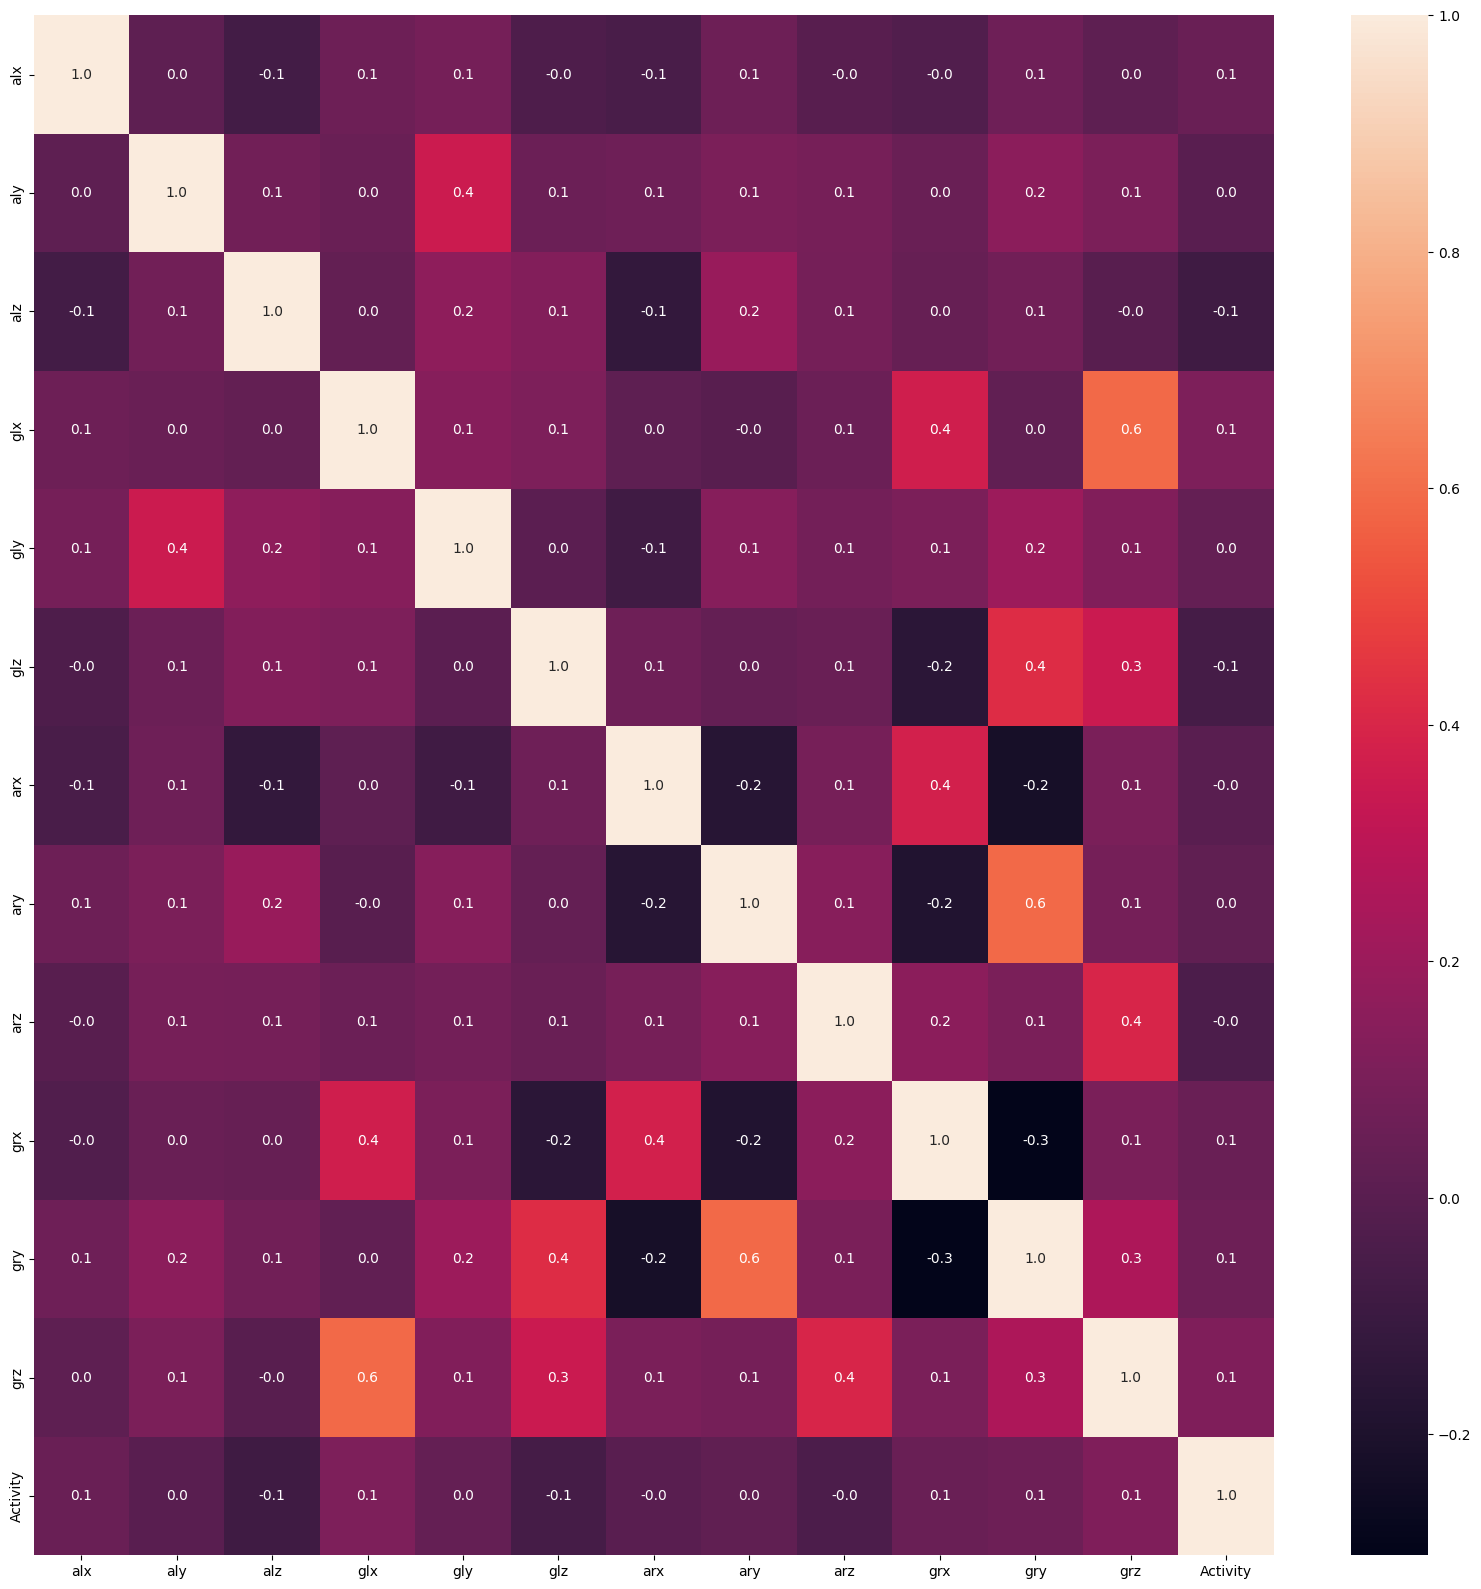

In [3]:
# Plotting the correlation matrix
corr = df_health.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt='.1f')

### Data Cleaning 

In [4]:
# Downsample majority class so as to obtain a balanced dataset
from sklearn.utils import resample
 
df_health_majority = df_health[df_health['Activity'] == 0]
print("The majority class is: ", df_health_majority.shape)
df_health_minorities = df_health[df_health['Activity'] != 0]
print("The minority classes are: ", df_health_minorities.shape)


df_health_majority_downsampled = resample(df_health_majority, n_samples=30000, random_state=42)
df_health = pd.concat([df_health_majority_downsampled, df_health_minorities])
df_health['Activity'].value_counts()
print('This is the number of samples for each label in our processed dataset')

The majority class is:  (872550, 14)
The minority classes are:  (343195, 14)
This is the number of samples for each label in our processed dataset


In [5]:
#Dropping feature with data outside 98% confidence interval in order to remove outliers
df_health1 = df_health.copy()
for feature in df_health1.columns[:-2]:
  lower_range = np.quantile(df_health[feature],0.01) # quantile basically gives us the percentile distribution of the feature and its entries
  upper_range = np.quantile(df_health[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df_health1 = df_health1.drop(df_health1[(df_health1[feature]>upper_range) | (df_health1[feature]<lower_range)].index, axis=0)
  print('shape',df_health1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [6]:
# Mappping the labels to the activities
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

### Preprocessing Data for Model

In [7]:
# spliting data into train and test set
print(df_health1.shape)
train = df_health1[(df_health1['subject'] != 'subject10') & (df_health1['subject'] != 'subject9')]
test = df_health1.drop(train.index, axis=0)
print(train.shape,test.shape)

(310929, 14)
(246501, 14) (64428, 14)


In [8]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(246501, 12) (246501,) (64428, 12) (64428,)


In [9]:
# segregating various features wrt to the body parts
X_train_ankle = X_train[['alx','aly','alz','glx','gly','glz']];
X_train_arm = X_train[['arx','ary','arz','grx','gry','grz']];
X_test_ankle = X_test[['alx','aly','alz','glx','gly','glz']];
X_test_arm = X_test[['arx','ary','arz','grx','gry','grz']];
y_train_ankle = y_train
y_train_arm = y_train
y_test_ankle = y_test
y_test_arm = y_test
print(X_train_ankle.shape,X_train_arm.shape,X_test_ankle.shape,X_test_arm.shape)

(246501, 6) (246501, 6) (64428, 6) (64428, 6)


In [10]:
from scipy import stats

#function to create time series datset for sequence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
# Creating time series dataset with both ankle and arm data
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
print(X_train.shape, y_train.shape)
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
print(X_test.shape, y_test.shape)

/tmp/ipykernel_142/3465284889.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
(4929, 100, 12) (4929, 1)
(1287, 100, 12) (1287, 1)


In [12]:
# Creating time series dataset with ankle data and arm data separately
X_train_ankle,y_train_ankle = create_dataset(X_train_ankle, y_train_ankle, 100, step=50)
X_train_arm,y_train_arm = create_dataset(X_train_arm, y_train_arm, 100, step=50)
X_test_ankle,y_test_ankle = create_dataset(X_test_ankle, y_test_ankle, 100, step=50)
X_test_arm,y_test_arm = create_dataset(X_test_arm, y_test_arm, 100, step=50)
print(X_train_ankle.shape,y_train_ankle.shape,X_train_arm.shape,y_train_arm.shape)

/tmp/ipykernel_142/3465284889.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
(4929, 100, 6) (4929, 1) (4929, 100, 6) (4929, 1)


# Model building

In [29]:
from tensorflow.keras.models import Model

# Input layer => 100 time steps and 12 features at each time step
inputs = layers.Input(shape=[100,12])

# Conv1D layer, with 16 filters, kernel size 3, and padding
cv1d = layers.Conv1D(filters=16, kernel_size=3, padding="same")(inputs)

# Batch normalization layer followed by dropout layer
bn = layers.BatchNormalization()(cv1d)
dropout = layers.Dropout(0.2)(bn)

# First LSTM layer with 64 units with attention layer => calculates the attention scores between the query and value features obtained from the first LSTM layer
#lstm1 = layers.LSTM(64,return_sequences=True)
#query_features = lstm1(dropout)
#value_features = lstm1(dropout)
#attention = layers.Attention()([query_features,value_features])

# Second LSTM layer with 64 units with attention layer
lstm2 = layers.LSTM(64,return_sequences=True)
query_features = lstm2(dropout)
value_features = lstm2(dropout)
attention2 = layers.Attention()([query_features,value_features])

# Branch 1: Third LSTM layer with 64 units
lstm3 = layers.LSTM(64)(attention2)

# Branch 2: Dense layer with 64 units followed by batch normalization and dropout layer
# Then another dense layer with 64 units followed by batch normalization and dropout layer
branch1 = layers.Dense(units = 64, activation='relu')(lstm3)
bn1 = layers.BatchNormalization()(branch1)
#dropout1 = layers.Dropout(0.2)(bn1)
#dense2 = layers.Dense(units = 64, activation='relu')(dropout1)
#bn2 = layers.BatchNormalization()(dense2)
dropout2 = layers.Dropout(0.2)(bn1)#insead of bn2 bn1

# Branch 3: Dense layer with 64 units followed by batch normalization and dropout layer
# Then another dense layer with 64 units followed by batch normalization and dropout layer
#branch2 = layers.Dense(units = 64, activation='relu')(lstm3)
#bn3 = layers.BatchNormalization()(branch2)
#dropout3 = layers.Dropout(0.2)(bn3)
#dense3 = layers.Dense(units = 64, activation='relu')(dropout3)
#bn4 = layers.BatchNormalization()(dense3)
#dropout4 = layers.Dropout(0.2)(bn4)

# Concatenate the two branches
concatenated = layers.concatenate([lstm3,dropout2]) #,dropout4

# Dense layer with 64 units followed by batch normalization and dropout layer
dense4 = layers.Dense(units = 64, activation = 'relu')(concatenated)
outputs = layers.Dense(units = 13, activation='softmax')(dense4)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
# Compile the model with adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [30]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 100, 16)      592         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 100, 16)     64          ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 dropout_9 (Dropout)            (None, 100, 16)      0           ['batch_normalization_9[0][

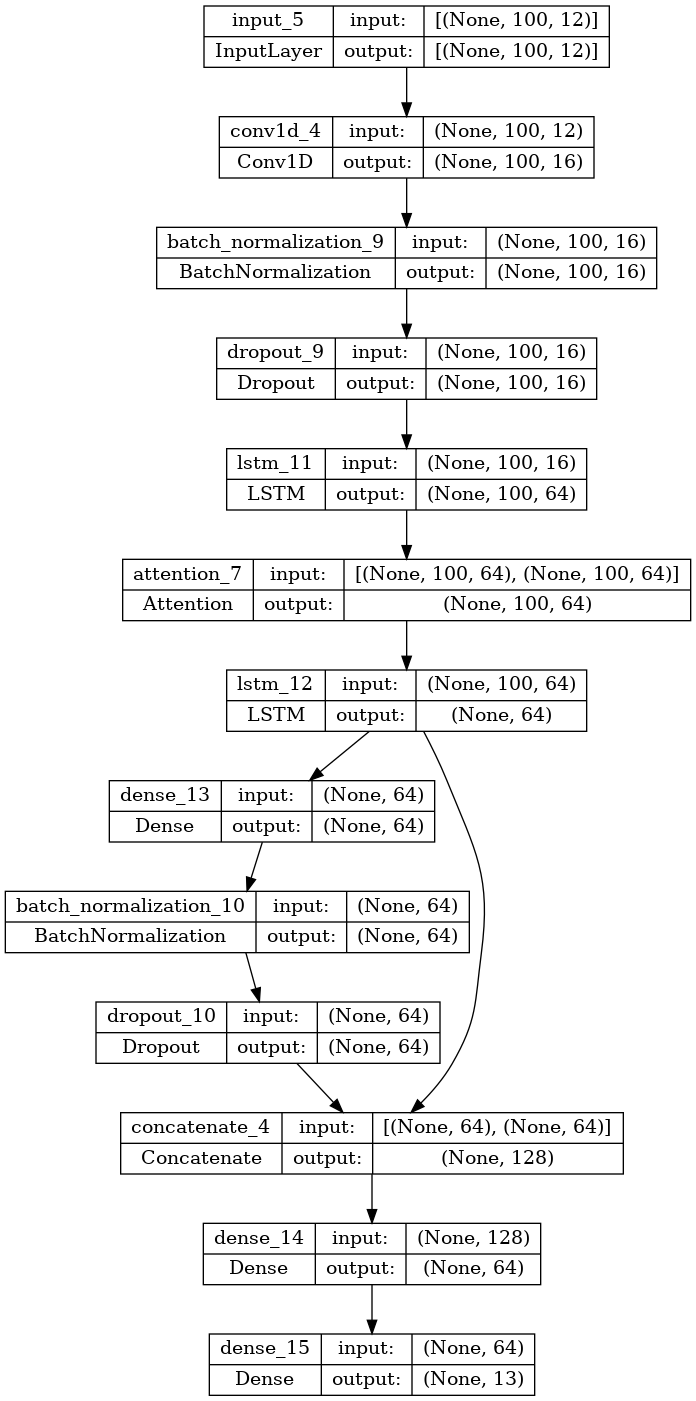

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file = 'model.png')

In [32]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
2023-07-18 11:13:33.840740: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
155/155 [==============================] - 39s 225ms/step - loss: 0.8179 - sparse_categorical_accuracy: 0.7480 - val_loss: 1.1649 - val_sparse_categorical_accuracy: 0.6488
Epoch 2/10
155/155 [==============================] - 34s 220ms/step - loss: 0.2466 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.2375 - val_sparse_categorical_accuracy: 0.9378
Epoch 3/10
155/155 

# Model Evaluation

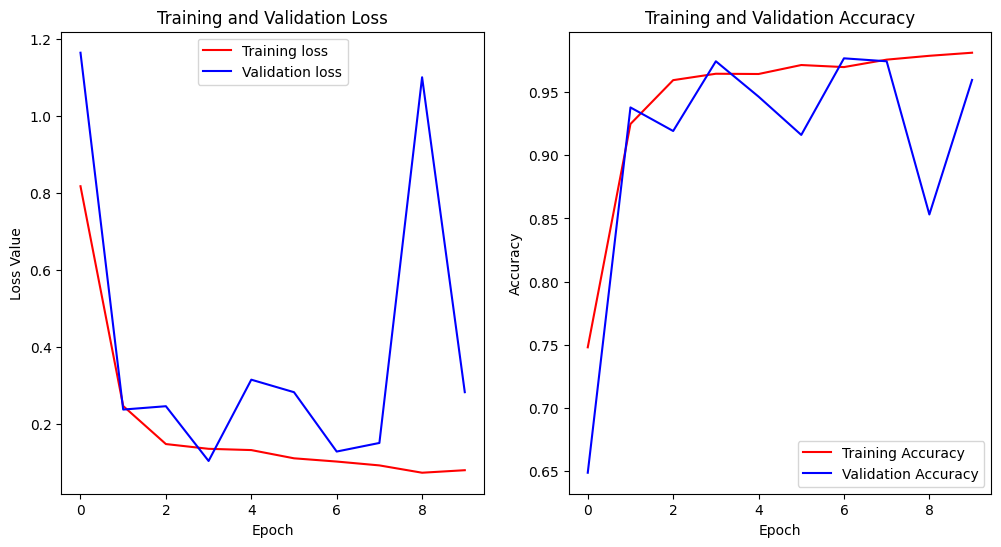

In [33]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

2023-07-18 11:19:26.220255: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
41/41 [==============================] - 2s 50ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.9744
Train accuracy 96.31 %
Train loss 0.115685373544693
Test accuracy 97.44 %
Test loss 0.10383155196905136


In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)
print(pred.shape,y_test.shape)

2023-07-18 11:03:48.661523: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-07-18 11:03:48.661785: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2649 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, 

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
 
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      0.99      1.00       123
           2       1.00      0.61      0.76       123
           3       1.00      1.00      1.00       122
           4       0.99      0.99      0.99       120
           5       0.99      0.98      0.98        84
           6       0.96      0.97      0.97       106
           7       0.68      0.98      0.81       112
           8       0.97      0.96      0.96       116
           9       0.99      0.99      0.99       121
          10       0.99      0.99      0.99        89
          11       0.98      1.00      0.99        52
          12       1.00      1.00      1.00        27

    accuracy                           0.95      1287
   macro avg       0.97      0.96      0.96      1287
weighted avg       0.96      0.95      0.95      1287

**************************************************
[[ 92   0   0   0   0   0   

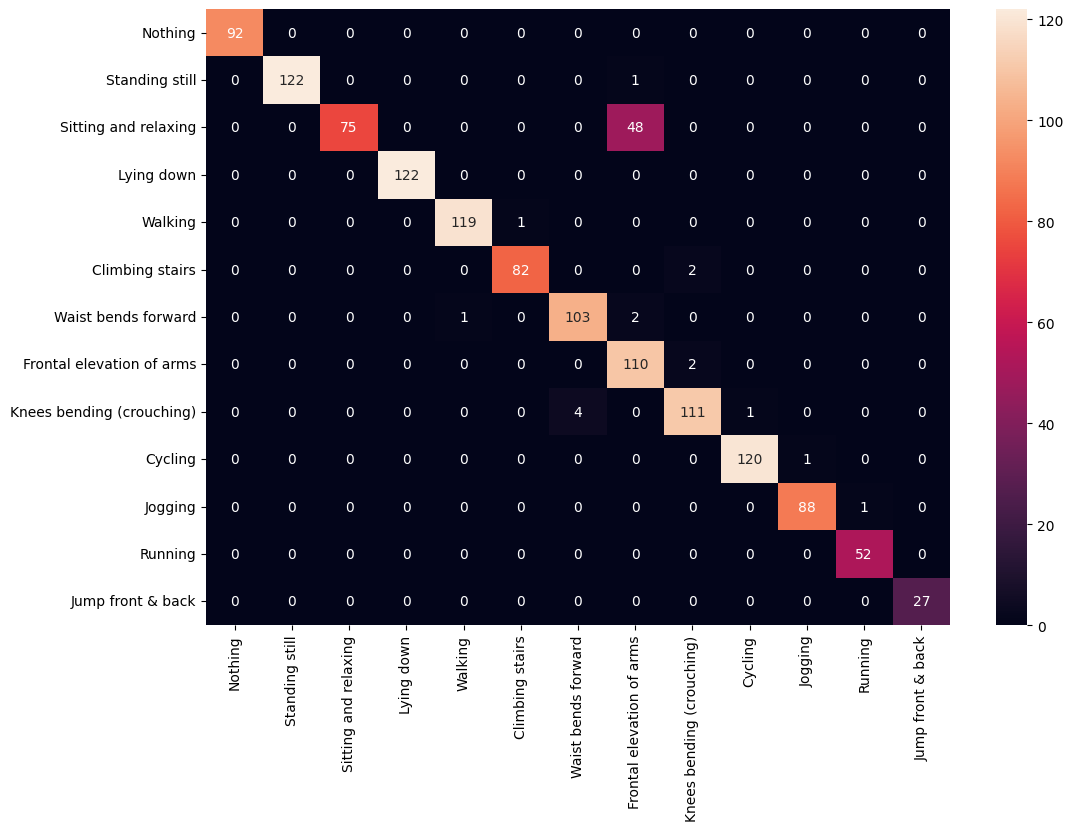

In [26]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=adc144b1-5328-4efa-88c2-7117c387534e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>